<a href="https://colab.research.google.com/github/KeerthiPrabu/dl-tools-lab/blob/main/Transfer_and_freeze_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

In [2]:
train_ds, test_ds = cifar10.load_data() 
split = int(train_ds[0].shape[0]*.75)
train_ds,val_ds = (train_ds[0][:split],train_ds[1][:split]),(train_ds[0][split:],train_ds[1][split:])
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds)
test_ds = tf.data.Dataset.from_tensor_slices(test_ds)

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
def show_images(images):
    n = len(images)
    for i,image in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

In [4]:
data_augumentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(32,32),
    tf.keras.layers.Rescaling(1/256),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(factor=.2),
    tf.keras.layers.RandomZoom(height_factor=.1, width_factor=.1),
    tf.keras.layers.RandomContrast(factor=(.2,.8))
])

In [5]:
def preprocess(x, y):
   return data_augumentation(x), tf.one_hot(tf.squeeze(y),10)

In [6]:
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


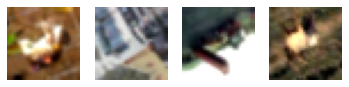

In [7]:
show_images(train_ds.take(4).map(lambda x,y: x))

In [8]:
train_ds = train_ds.batch(64)
val_ds = val_ds.batch(64)
test_ds = test_ds.batch(64)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
base_model = tf.keras.applications.VGG16(include_top=False,weights = "imagenet",input_shape=(32,32,3))
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [10]:
for layer in base_model.layers:
    layer.trainable=False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [11]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)               

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
history_1=model.fit(train_ds,validation_data = val_ds,epochs=5)

Epoch 1/5
586/586 [==============================] - 511s 870ms/step - loss: 1.7360 - accuracy: 0.3716 - val_loss: 1.6403 - val_accuracy: 0.4090
Epoch 2/5
586/586 [==============================] - 484s 827ms/step - loss: 1.5658 - accuracy: 0.4426 - val_loss: 1.5637 - val_accuracy: 0.4387
Epoch 3/5
586/586 [==============================] - 483s 824ms/step - loss: 1.5324 - accuracy: 0.4531 - val_loss: 1.5376 - val_accuracy: 0.4534
Epoch 4/5
586/586 [==============================] - 482s 823ms/step - loss: 1.4942 - accuracy: 0.4699 - val_loss: 1.5072 - val_accuracy: 0.4630
Epoch 5/5
586/586 [==============================] - 481s 822ms/step - loss: 1.4758 - accuracy: 0.4773 - val_loss: 1.4938 - val_accuracy: 0.4660


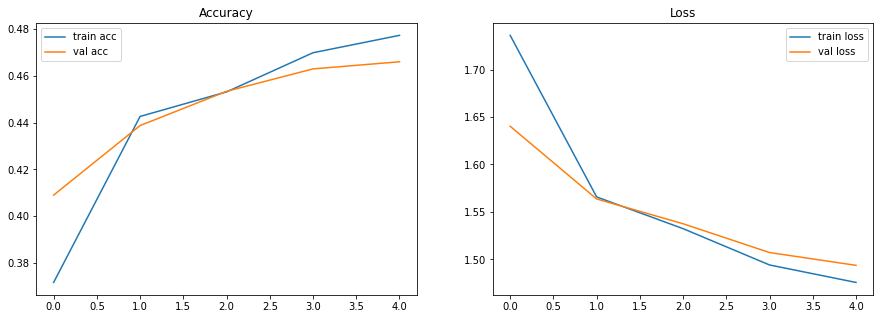

In [14]:
history_1 = history_1.history

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history_1["accuracy"],label="train acc")
plt.plot(history_1["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history_1["loss"],label="train loss")
plt.plot(history_1["val_loss"],label="val loss")
plt.legend()

plt.show()

In [15]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

157/157 [==============================] - 98s 619ms/step - loss: 1.5059 - accuracy: 0.4622
Loss:  1.5059376955032349
Accuracy:  0.46219998598098755


In [16]:
for layer in base_model.layers[15:]:
    layer.trainable = True
base_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f299c230d90>>

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
history_2=model.fit(train_ds,validation_data = val_ds,epochs=5)

In [ ]:
history_2 = history_2.history

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history_2["accuracy"],label="train acc")
plt.plot(history_2["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history_2["loss"],label="train loss")
plt.plot(history_2["val_loss"],label="val loss")
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
